# Host Tracker

This jupyter notebook file contains the code used to produce the host tracker for the Airbnb dataset. It is an operational dashboard meant to help managers understand which hosts are doing well (expected to grow) and which hosts are underperforming, in line with their quality control programs. By understanding the data in this dashboard including reviews, host information, and availability, they can offer recommendations to hosts to improve their ratings and revenue. This will lead to a higher retention rate of hosts and therefore more supply of accommodation offerings for Airbnb.

### 1. Importing the Libraries and Data

In [324]:
#Importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as sp

import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff

import warnings
warnings.filterwarnings('ignore')

from subprocess import check_output

from dash import Dash, html, dash_table, dcc
import dash_bootstrap_components as dbc
import plotly.express as px

print("Libraries successfully imported!")

Libraries successfully imported!


In [325]:
airbnb = pd.read_excel("airbnb.xlsx")
print("Airbnb data successfully imported!")

Airbnb data successfully imported!


### 2. Data Cleaning

In [326]:
#Checking the number of listings and number of columns.
listings = airbnb.shape[0]
attributes = airbnb.shape[1]

print(f"There are {listings} listings. Each listing has {attributes} attributes.")

There are 2709 listings. Each listing has 75 attributes.


In [ ]:
#Cleaning the price column to be formatted as a float variable.
airbnb['price'] = airbnb['price'].apply(lambda x: float(str(x).replace("$", "").replace(",", "")) if isinstance(x, str) else x)

# Removing outliers
Q1 = airbnb['price'].quantile(0.25)
Q3 = airbnb['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
properties_df = airbnb[(airbnb['price'] >= lower_bound) & (airbnb['price'] <= upper_bound)]

In [ ]:
#Converting First Review to Datetime for line graphs
airbnb['first_review'] = pd.to_datetime(airbnb["first_review"])

In [331]:
airbnb.head()
print(dict(airbnb.isna().sum()[airbnb.isna().sum() > 0]))

#Key Missing Host Figures: Host Response Time (550), Host Response Rate (550), Host Acceptance Rate (297)
#Host Review Scores: There are 330 listings without reviews (no first/last review or scores).
#Neighbourhood_group_cleansed, calendar_updated, and license have 2709 missing values, indicating an issue with the scrape.

{'description': 43, 'neighborhood_overview': 1275, 'host_location': 520, 'host_about': 1134, 'host_response_time': 550, 'host_response_rate': 550, 'host_acceptance_rate': 297, 'host_is_superhost': 22, 'host_neighbourhood': 2617, 'neighbourhood': 1275, 'neighbourhood_group_cleansed': 2709, 'bathrooms': 603, 'bathrooms_text': 1, 'bedrooms': 183, 'beds': 605, 'price': 602, 'calendar_updated': 2709, 'has_availability': 29, 'first_review': 330, 'last_review': 330, 'review_scores_rating': 330, 'review_scores_accuracy': 330, 'review_scores_cleanliness': 330, 'review_scores_checkin': 330, 'review_scores_communication': 330, 'review_scores_location': 330, 'review_scores_value': 330, 'license': 2709, 'reviews_per_month': 330}


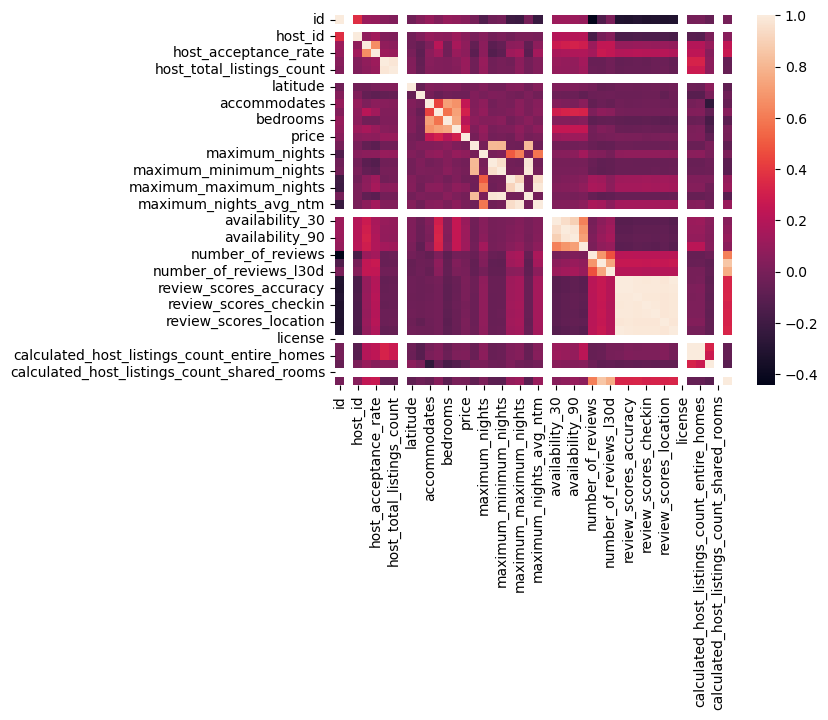

In [ ]:
#Checking which null values are correlated

nulls = airbnb[airbnb.isna().any(axis = 1)]

null_matrix = nulls.fillna(0).corr(numeric_only = True)

sns.heatmap(null_matrix)

plt.show()

#Nothing particularly interesting.

In [333]:
#Checking the listings without a description
print(airbnb[airbnb["description"].isna()][["description", "listing_url"]].head())

#The listings do have a description. It looks like an error with the scrape, rather than a lack of description.

   description                           listing_url
7          NaN   https://www.airbnb.com/rooms/407485
8          NaN   https://www.airbnb.com/rooms/422956
11         NaN   https://www.airbnb.com/rooms/942226
12         NaN   https://www.airbnb.com/rooms/975170
18         NaN  https://www.airbnb.com/rooms/1457693


In [334]:
#Checking the listings without beds
print(airbnb[airbnb["beds"].isna()][["description", "bedrooms", "price", "listing_url", "availability_365"]].head())
print(airbnb[~airbnb["beds"].isna()][["description", "bedrooms", "price", "listing_url"]].head())

#Null bedroom values appears to be a scrape error. They do have bedrooms.
#Null price values appears to be due to dynamic pricing and/or a lack of availability.

                                          description  bedrooms  price  \
4   A room with a shared bathroom in an old Victor...       NaN    NaN   
10  This is a very friendly house. So it's a home ...       NaN    NaN   
12                                                NaN       NaN    NaN   
18                                                NaN       NaN    NaN   
19  Wake up in the cast iron bedstead with the sun...       NaN    NaN   

                             listing_url  availability_365  
4    https://www.airbnb.com/rooms/390781                 0  
10   https://www.airbnb.com/rooms/868888                 0  
12   https://www.airbnb.com/rooms/975170                 0  
18  https://www.airbnb.com/rooms/1457693                 0  
19  https://www.airbnb.com/rooms/1536968                 0  
                                         description  bedrooms  price  \
0  A good sized room with a comfy double bed and ...       1.0   40.0   
1  My Harbourside apartment centrally locat

### Visualisations

1. Location of Properties in Bristol: This geospatial graph is used to identified where properties are located in Bristol and whether certain areas are more popular than others, based on overall review scores.

In [ ]:
#Creating a simple dataframe for storage
properties_df = airbnb[["latitude", "longitude", "review_scores_rating", "price", "host_name", 'property_type', 'neighbourhood_cleansed']] # I reaslised this was unnecessary later, but the code still works.
properties_df = properties_df.rename(columns = {'review_scores_rating':'Rating', 'price': "Price", "host_name": "Host", "property_type":"Property Type", "neighbourhood_cleansed":"Neighborhood"})
properties_df.dropna(inplace = True)

# Removing outliers
Q1 = properties_df['Price'].quantile(0.25)
Q3 = properties_df['Price'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for acceptable 'Price' values
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
properties_df = properties_df[(properties_df['Price'] >= lower_bound) & (properties_df['Price'] <= upper_bound)]
avg_price = round(properties_df["Price"].mean(),2)

# Plotting the data after removing outliers
fig_map = px.scatter_mapbox(properties_df, 
                            lat="latitude", 
                            lon="longitude",  
                            color="Price",
                            zoom = 10,
                            mapbox_style="carto-positron",
                            hover_data = ["Host", "Rating", "Property Type", "Neighborhood"],
                            color_continuous_scale=[(0, "#FFEBED"), (1, "red")])

fig_map.update_layout(
    title_text= "Listing Prices in Bristol (£) by location.",
    title_font=dict(
        family="Arial",  
        weight=50       
    )
)

fig_map.show()

2. ADR by Neighborhood: Neighborhoods may have some intrisic value to them, such as a superior location near landmarks or a better community. Average Daily Revenue measures the average daily rate for a room.

In [ ]:
import plotly.express as px

# Compute mean prices by neighborhood
mean_prices = properties_df.groupby("Neighborhood")["Price"].mean().reset_index(name="Mean Price (£)")
mean_prices = mean_prices.sort_values(by="Mean Price (£)", ascending=True)

# Create bar plot with color scale based on price
fig_price = px.bar(
    mean_prices,
    x="Neighborhood",
    y="Mean Price (£)",
    color="Mean Price (£)",
    title="Mean Neighbourhood Prices (£)",
    template='plotly_white',
    color_continuous_scale=[(0.0, "#FFEBED"), (1.0, "red")]
)

#Setting the hotel average to the Booking.com average in Bristol
hotel_average = 112

# Add horizontal reference line at the hotel average.
fig_price.add_shape(
    type="line",
    x0=-0.5,  # Start before first bar
    x1=len(mean_prices) - 0.5,  # End after last bar
    y0=hotel_average,
    y1=hotel_average,
    line=dict(color="grey", width=2, dash="dash"),
    xref="x",
    yref="y"
)

#And the annotation
fig_price.add_annotation(
    x=len(mean_prices) - 1,
    y=hotel_average,
    text=f"Booking.com Average: £{hotel_average}",
    showarrow=False,
    xshift = -350,
    yshift=15,
    font=dict(size=16, color="grey")
)

fig_price.show()


2. Growth of Listing Supply Over Time: A line chart which shows the growth of reviewed properties over time. Since the date the property was first listed is not available, this is used as a proxy.

In [346]:
# Group by 'first_review' and 'property_type' to count occurrences
listing_supply_counts = airbnb.groupby(['first_review', 'property_type']).size().reset_index(name='count')

# Compute cumulative sum for each 'property_type' over time
listing_supply_counts['cumulative_sum'] = listing_supply_counts.groupby('property_type')['count'].cumsum()

# Find the maximum cumulative sum for each property type
max_cumulative_sum_per_property = listing_supply_counts.groupby('property_type')['cumulative_sum'].max()

# Identify property types where the maximum cumulative sum is less than 80
small_property_types = max_cumulative_sum_per_property[max_cumulative_sum_per_property < 80].index

# Replace property types with max cumulative sum < 80 with "Other"
listing_supply_counts['property_type'] = listing_supply_counts['property_type'].apply(
    lambda x: 'Other' if x in small_property_types else x
)

# Recalculate cumulative sum after grouping smaller property types
listing_supply_counts['cumulative_sum'] = listing_supply_counts.groupby('property_type')['count'].cumsum()

# Rename columns
listing_supply_counts = listing_supply_counts.rename(columns={
    "cumulative_sum": "Cumulative First Reviews",
    "property_type": "Property Type",
    "first_review": "First Review"
}).sort_values(by = "Cumulative First Reviews", ascending = False)

# Create a line plot with sorted legend
fig_listing_supply = px.line(
    listing_supply_counts, 
    x='First Review', 
    y='Cumulative First Reviews', 
    color='Property Type', 
    template='plotly_white',
    title='Cumulative Sum of Listings Over Time by Property Type' 
)

# Show the plot
fig_listing_supply.show()

3. Growth of Hosts over Time: Similar to looking at the growth of listings over time, it's interesting to see whether hosts have grown over time, especially by Cluster.

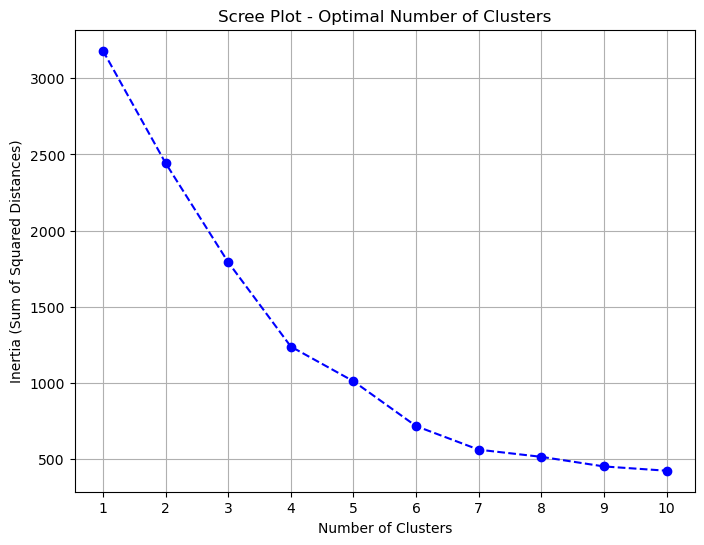

In [ ]:
#Importing libraries for clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# Group by host and summarize important metrics
host_df = airbnb.groupby('host_id').agg({
    'review_scores_rating': 'mean',
    'price': 'mean',
    'latitude': 'mean',
    'longitude': 'mean',
    'id': 'count' ,
    'room_type': lambda x: x.unique()
}).reset_index()

# Rename columns for clarity
host_df = host_df.rename(columns={
    'review_scores_rating': 'avg_rating',
    'price': 'avg_price',
    'id': 'num_listings'
})

# Handling missing values - clustering algorithim won't work with missnig values.
host_df = host_df.dropna()

# Selecting the three features for clustering
features = ['avg_rating', 'avg_price', 'num_listings']

# Normalizing the features
scaler = StandardScaler()
host_scaled = scaler.fit_transform(host_df[features])

# List to store the inertia (sum of squared distances to closest cluster center)
inertia = []

# Creating 10 clusters
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(host_scaled)  # Fit on the scaled data
    inertia.append(kmeans.inertia_)

# Create the scree plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--', color='b')
plt.title('Scree Plot - Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(range(1, 11))  # Ensure the x-axis shows all cluster numbers
plt.grid(True)
plt.show()

In [ ]:
# Apply K-Means clustering with k = 4 seeing the elbow in the scree plot.
kmeans = KMeans(n_clusters=4, random_state=42)
host_df['cluster'] = kmeans.fit_predict(host_scaled)

# Merging the 'host_df' with the original 'airbnb' dataset to add the 'cluster' column
airbnb = airbnb.merge(host_df[['host_id', 'cluster']], on='host_id', how='left')

In [339]:
# Group by 'cluster' and calculate the mean for the numerical columns
cluster_summary = host_df.groupby('host_cluster')[['avg_rating', 'avg_price', 'num_listings']].mean()

# Display the cluster summary
print(cluster_summary)

              avg_rating   avg_price  num_listings
host_cluster                                      
0               4.856161  161.259750      1.984940
1               4.863940   68.895342      1.360584
2               4.613910  142.540001     84.666667
3               3.781996   87.691340      3.375000


In [ ]:
#Assigning the cluster summary to a dataframe for later use.

host_cluster_info = pd.DataFrame(cluster_summary).reset_index()

# Define a mapping of clusters to meaningful names
cluster_names = {
    0: 'Small Airbnb Host', #High average ratings, high average price, approximately two listings
    1: 'Casual Airbnb Host', #High average ratings, low average price, few listings
    2: 'Professional Airbnb Host', #High average ratings, high average price, many listings
    3: 'Struggling Airbnb Host' #Low ratings, low average price, some listings
}

host_cluster_info['host_cluster_name'] = host_cluster_info['host_cluster'].map(cluster_names)
host_cluster_info = host_cluster_info.round(2)

In [341]:
# Map the clusters in the airbnb dataset to their new names
airbnb['host_cluster_name'] = airbnb['host_cluster'].map(cluster_names)

airbnb['host_cluster_name'] = airbnb['host_cluster_name'].fillna('Unclustered')

# Check the result
print(airbnb[['host_id', 'host_cluster', 'host_cluster_name']].head(10))

   host_id  host_cluster   host_cluster_name
0   360195           1.0  Casual Airbnb Host
1   591555           1.0  Casual Airbnb Host
2   708175           1.0  Casual Airbnb Host
3  1582810           1.0  Casual Airbnb Host
4  1954565           NaN         Unclustered
5  1956028           1.0  Casual Airbnb Host
6  1941316           1.0  Casual Airbnb Host
7  2029719           1.0  Casual Airbnb Host
8  2103297           0.0   Small Airbnb Host
9  3996407           0.0   Small Airbnb Host


In [343]:
# Define the custom color palette
custom_colors = ['#FF5A5F', '#00A699', '#FC642D', '#484848', 'lightgrey']

# First listings per host
first_listings = airbnb.drop_duplicates(subset="host_id", keep="first")

# Drop rows where cluster name is missing
first_listings = first_listings.dropna(subset=["host_cluster_name"])

# Group by 'host_since' and 'host_cluster_name' to count number of new hosts per date per cluster
host_supply_counts = first_listings.groupby(['host_since', 'host_cluster_name']).size().reset_index(name='count')

# Sort by date within each cluster
host_supply_counts = host_supply_counts.sort_values(by=['host_cluster_name', 'host_since'])

# Calculate cumulative hosts per cluster
host_supply_counts['Cumulative Hosts'] = host_supply_counts.groupby('host_cluster_name')['count'].cumsum()

# Rename columns
host_supply_counts = host_supply_counts.rename(columns={"host_since": "Host Since", "host_cluster_name": "Cluster"}).sort_values(by = "Cumulative Hosts", ascending = False)

# Plot cumulative host supply over time, split by cluster
fig_host_supply = px.line(
    host_supply_counts, 
    x='Host Since', 
    y='Cumulative Hosts',  
    color='Cluster',
    title='Cumulative Sum of Hosts Over Time by Cluster',
    template='plotly_white',
    color_discrete_map={
        "Casual Airbnb Host": custom_colors[0],
        "Unclustered": custom_colors[1],
        "Small Airbnb Host": custom_colors[2],
        "Professional Airbnb Host": custom_colors[3],
        "Struggling Airbnb Host": custom_colors[4]
    },
)

# Show plot
fig_host_supply.show()



4. Availability: The histrogram is used to show accommodation availability in Bristol over the next year. The user can drill down further using the dropdown tool.

In [351]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create a 1x4 subplot layout
fig_availability = make_subplots(rows=1, cols=2, subplot_titles=[
    "Availability in 90 Days", 
    "Availability in 365 Days"
])

# Define colors for each histogram
colors = ["#FF5A5F", "#00A699"]

# Add histograms
availability_cols = ['availability_90', 'availability_365']
for i, col in enumerate(availability_cols):
    fig_availability.add_trace(go.Histogram(x=airbnb[col], marker_color=colors[i], name=col), row=1, col=i+1)

fig_availability.update_traces(marker=dict(
    line=dict(color='white', width=1)  # White border, 1px width
))

fig_availability.update_xaxes(title_text="Available Days", row=1, col=1)
fig_availability.update_xaxes(title_text="Available Days", row=1, col=2)
fig_availability.update_yaxes(title_text="Listings", row = 1, col = 1)

# Update layout
fig_availability.update_layout(
    title_text="Availability Distribution",
    showlegend=False,
    template = 'plotly_white',
)

fig_availability.show()


In [356]:
#Number of Hosts
num_hosts = len(airbnb["host_id"].unique())
print(f"There are {num_hosts} hosts.")

# Calculate the number of hosts per year
airbnb["host_since"] = pd.to_datetime(airbnb["host_since"])  # Ensure 'host_since' is in datetime format
airbnb["host_year"] = airbnb["host_since"].dt.year

# Get the count of hosts for the current year and 2023
current_year = 2024
previous_year = current_year-1
hosts_since_current_year = airbnb[airbnb["host_year"] <= current_year]["host_id"].nunique()
hosts_since_2023 = airbnb[airbnb["host_year"] <= previous_year]["host_id"].nunique()
hosts_current_year = airbnb[airbnb["host_year"] == current_year]["host_id"].nunique()
hosts_2023 = airbnb[airbnb["host_year"] == previous_year]["host_id"].nunique()

percent_diff_hosts = round(((hosts_since_current_year - hosts_since_2023) / hosts_since_current_year) * 100, 2)


# Print the results
print(f"Number of hosts in {current_year}: {hosts_since_current_year}")
print(f"Number of hosts in 2023: {hosts_since_2023}")
print(f"Percentage difference in hosts from 2023 to {current_year}: {percent_diff_hosts:.2f}%")

#Number of Listings
print(f"There are {listings} listings.")

# Number of listings in current year and 2023
airbnb["review_year"] = airbnb["first_review"].dt.year
listings_current_year = airbnb[airbnb["review_year"] == current_year]["id"].nunique()
listings_2023 = airbnb[airbnb["review_year"] == 2023]["id"].nunique()

# Calculate the percentage difference
if listings_2023 != 0:
    percent_diff_listings = round(((listings_current_year - listings_2023) / listings_2023) * 100, 2)
else:
    percent_diff_listings = float("inf")  # Handle division by zero

# Print the results
print(f"Number of first reviews {current_year}: {listings_current_year}")
print(f"Number of first reviews in 2023: {hosts_2023}")
print(f"Percentage difference in first listings from 2023 to {current_year}: {percent_diff_listings:.2f}%")

#Average Number of Properties
avg_properties = airbnb.shape[0]/num_hosts
print(f"A host has on average {avg_properties} properties")

#ADR
print(f"The average price of a airbnb in Bristol is {avg_price}")

percent_diff_adr = round((hotel_average - avg_price) / hotel_average * 100, 2)
print(f"Bristol's average ADR is {percent_diff_adr}% less than the national average.")

less_than_hotel = properties_df[properties_df["Price"]<hotel_average].shape[0]
proportion_less_than_hotel = round((less_than_hotel/listings)*100,2)

print(f"There are {less_than_hotel} properties less than the {hotel_average}")
print(f"There are {proportion_less_than_hotel}% properties less than {hotel_average}")

#Average Availability
avg_90_availability = round(airbnb["availability_90"].mean())
print(f"The average availability in the next 90 days is {avg_90_availability}")

occupancy_rate = round(avg_90_availability/90*100,2)
print(f"The occupancy rate the average occupancy rate in the next 90 days is {occupancy_rate}%")

occupancy_rate_diff = round(70 - occupancy_rate, 2)
print(f"The occupancy rate is {occupancy_rate_diff} less than the national average")



There are 1646 hosts.
Number of hosts in 2024: 1646
Number of hosts in 2023: 1549
Percentage difference in hosts from 2023 to 2024: 5.89%
There are 2709 listings.
Number of first reviews 2024: 663
Number of first reviews in 2023: 84
Percentage difference in first listings from 2023 to 2024: 41.97%
A host has on average 1.6458080194410694 properties
The average price of a airbnb in Bristol is 101.81
Bristol's average ADR is 9.1% less than the national average.
There are 1097 properties less than the 112
There are 40.49% properties less than 112
The average availability in the next 90 days is 48
The occupancy rate the average occupancy rate in the next 90 days is 53.33%
The occupancy rate is 16.67 less than the national average


## Integrating the Visualisations into a Dashboard

In [369]:
card_bristol_overview = dbc.Card([
    dbc.CardHeader("Bristol Affordability and Listing Growth Overview", style={"background-color": "#ff5a5f", "color": "white", "font-size":"25pt", "font-weight":"bold"}),

    dbc.CardBody([
        # Row 1: KPI Cards
        dbc.Row([
            dbc.Col(dbc.Card(dbc.CardBody([
                html.H4("Number of Listings", className="card-title", style={"font-weight":"bold"}),
                html.H2([
                    html.Span(f"{listings:,}", style={"color": "green", "font-weight":"bold"}),
                    html.Br(),  # Line break for spacing
                    html.Span(f"Annual Listing Growth (First Reviews): {listings_current_year-listings_2023} (+{percent_diff_listings:.2f}%)", style = {"font-size": "0.5em", "color": "black"})  # Small and black
                ], className="card-text")
            ]), style={"background-color": "#F8F9FA"}, outline=True), width=3),

            dbc.Col(dbc.Card(dbc.CardBody([
                html.H4("Average Daily Rate (ADR)", className="card-title", style={"font-weight":"bold"}),
                html.H2([
                    html.Span(f"£{avg_price}", style={"color": "green", "font-weight":"bold"}),
                    html.Br(),  # Line break for spacing
                    html.Span(f" Hotel Average: £{hotel_average} ({percent_diff_adr:.2f}% Difference, Accounting for Outliers)", style = {"font-size": "0.5em", "color": "black"})  # Small and black
                ], className="card-text")
            ]), style={"background-color": "#F8F9FA"}, outline=True), width=3),

            dbc.Col(dbc.Card(dbc.CardBody([
                html.H4("Number of Hosts", className="card-title", style={"font-weight":"bold"}),
                html.H2([
                    html.Span(f"{num_hosts:,}", style={"color": "green", "font-weight":"bold"}),
                    html.Br(),  # Line break for spacing
                    html.Span(f"Annual Host Growth: {hosts_current_year} (+{percent_diff_hosts:.2f}%)", style = {"font-size": "0.5em", "color": "black"})  # Small and black
                ], className="card-text")
            ]), style={"background-color": "#F8F9FA"}, outline=True), width=3),

            dbc.Col(dbc.Card(dbc.CardBody([
                html.H4("Occupancy Rate (90 Days)", className="card-title", style={"font-weight":"bold"}),
                html.H2([
                    html.Span(f"{occupancy_rate}%", style={"color": "red", "font-weight":"bold"}),  # Red main value
                    html.Br(),  # Line break for spacing
                    html.Span("UK Average: 70%", style={"font-size": "0.5em", "color": "black"})  # Small and black
                ], className="card-text")
            ]), style={"background-color": "#F8F9FA"}, outline=True), width=3),
        ], className="mb-4"),

        # Row 2: Market Visualizations
        dbc.Row([
            dbc.Col(dbc.Card(dbc.CardBody([
                html.H4(f"Only {less_than_hotel} ({proportion_less_than_hotel}%) Of Listings Are Less Than Booking.com...", className="card-title"),
                dcc.Graph(figure=fig_map)
            ]), color="light", outline=True), width=4),

            dbc.Col(dbc.Card(dbc.CardBody([
                html.H4("... And the Mean ADR of Most Neighbourhoods is Less Than Booking.com.", className="card-title"),
                dcc.Graph(figure=fig_price)
            ]), color="light", outline=True), width=8),
        
        ], className="mb-4"),

        dbc.Row([

            dbc.Col(dbc.Card(dbc.CardBody([
                html.H4("Available Listings Grow Exponentially Across Property Types...", className="card-title"),
                dcc.Graph(figure=fig_listing_supply)
            ]), color="light", outline=True), width=4),

            dbc.Col(dbc.Card(dbc.CardBody([
                html.H4(f"...Yet Annual Host Growth stagnates at {percent_diff_hosts}%...", className="card-title"),
                dcc.Graph(figure=fig_host_supply)
            ]), color="light", outline=True), width=4),

            dbc.Col(dbc.Card(dbc.CardBody([
                html.H4(f"... And The Average Listing is Available {avg_90_availability}/90 Days.", className="card-title"),
                dcc.Graph(figure=fig_availability)
            ]), color="light", outline=True), width=4),
            
            dbc.Col(dbc.Card(dbc.CardBody([
            html.H4("Airbnb Host Cluster Information", className="card-title"),
            dash_table.DataTable(
                columns=[
                    {"name": "Cluster", "id": "Cluster"},
                    {"name": "Average Rating", "id": "avg_rating"},
                    {"name": "Average Price", "id": "avg_price"},
                    {"name": "Number of Listings", "id": "num_listings"}
                ],
                data=[
                    {
                        "Cluster": cluster_names[cluster], 
                        "avg_rating": row["avg_rating"], 
                        "avg_price": row["avg_price"], 
                        "num_listings": row["num_listings"]
                    }
                    for cluster, row in host_cluster_info.iterrows()
                ],
                style_table={
                    'maxHeight': '250px',
                    'overflowY': 'auto',
                    'overflowX': 'auto'
                },
                style_cell={'textAlign': 'left', 'padding': '5px', 'fontFamily': 'Arial'},
                style_header={'backgroundColor': '#FF5A5F', 'color': 'white', 'fontWeight': 'bold', 'fontFamily': 'Arial'}
            )
        ]), color="light", outline=True), width=3)
        ], className="mb-4"),
    ])
], style={"width": "100%", "height": "100%"}, outline=True)

## Initializing the App

In [370]:
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = html.Div([
    dbc.Row([
        dbc.Col(card_bristol_overview, width = 12),
    ])
])

if __name__ == '__main__':
    app.run(jupyter_mode="external", debug=True, port=5082)


Dash app running on http://127.0.0.1:5082/


### Unused Graphs

In [ ]:
# Count number of listings per cluster
cluster_counts = airbnb['host_cluster_name'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Count']

# Create bar plot of cluster counts using Plotly Express
fig_clusters = px.bar(
    cluster_counts,
    y='Cluster',
    x='Count',
    color='Cluster',  # Gives color by cluster
    color_discrete_map={  # Use the same color mapping as before
        "Casual Airbnb Host": custom_colors[0],
        "Unclustered": custom_colors[1],
        "Small Airbnb Host": custom_colors[2],
        "Professional Airbnb Host": custom_colors[3],
        "Struggling Airbnb Host": custom_colors[4]
    },
    title='Number of First Listings per Cluster'
)

fig_clusters.update_layout(
    yaxis_title='Cluster',
    xaxis_title='Number of Listings',
    template='simple_white'
)

fig_clusters.show()

In [347]:
response = airbnb['host_response_time'].value_counts().reset_index(name = "count")

response['host_response_time'] = response['host_response_time'].replace({
    'within an hour': '⏳ Within 1 Hour',
    'within a few hours': '⏳ Few Hours',
    'within a day': '📆 Within 1 Day',
    'a few days or more': '📆 2+ Days'
})

response = response.rename(columns = {"host_response_time": "Response Time", "count": "# of Hosts"})

fig_response_time = px.bar(response,
                            x = "Response Time",
                            y = "# of Hosts",
                            title = "Host Response Times",
                            template = 'plotly_white',
                            color_discrete_sequence=["#FF5A5F"])

fig_response_time.show()

In [349]:
# Count occurrences of superhost values and calculate percentages
superhost = airbnb["host_is_superhost"].value_counts(normalize=True).reset_index(name="percentage")
superhost.rename(columns={"host_is_superhost": "Superhost"}, inplace=True)
superhost = superhost[superhost["Superhost"] == "t"]
superhost["Superhost"] = superhost["Superhost"].replace({"t": "Yes"})

superhost_count = airbnb.loc[airbnb["host_is_superhost"]=="t"].shape[0]

# Convert fraction to percentage (optional)
superhost["percentage"] *= 100  

# Create a bar chart with percentage values
fig_superhost = px.bar(superhost,
                       x="Superhost",
                       y="percentage",
                       text=superhost["percentage"].apply(lambda x: f"{x:.1f}%"),
                       labels={"percentage": "Percentage (%)", "t":"Superhost"},
                       template = "plotly_white",
                       color_discrete_sequence=["#00A699"],
                       title="Percentage of Superhosts")

# Customize layout for better visibility
fig_superhost.update_traces(textposition="outside")  # Show labels outside bars
fig_superhost.update_layout(yaxis_ticksuffix="%", yaxis_range=[0, 100])  # Ensure percentage format

fig_superhost.show()


In [ ]:
# Define the review score columns (original names)
score_columns = [
    "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness",
    "review_scores_checkin", "review_scores_communication", "review_scores_location",
    "review_scores_value"
]

worst_airbnbs_df = airbnb.sort_values(by = "review_scores_rating")[["id", "name", "host_name", "review_scores_rating"]]

# Capitalize and replace underscores for plotting purposes
display_columns = [x.split("_")[-1].capitalize() for x in score_columns]

# Compute the mean scores using original column names
mean_scores = airbnb[score_columns].mean()

# Create subplots (5 rows, 1 column)
fig_ratings = make_subplots(rows=5, cols=1, shared_xaxes=True)

# Add dot plots for each of the first five review scores with conditional coloring
for i, col in enumerate(display_columns[:5]):
    # Access the corresponding original column in airbnb DataFrame
    score = mean_scores[score_columns[i]]
    
    # Set the color based on the score
    if 4.75 <= score <= 4.8:
        dot_color = 'orange'
    elif score > 4.8:
        dot_color = 'green'
    else:
        dot_color = 'red'  # Default color for scores below 4.75
    
    fig_ratings.add_trace(go.Scatter(
        y=[col], 
        x=[score], 
        mode='markers',  # Use markers (dots)
        marker=dict(size=20, color=dot_color),  # Conditional color
        name=col
    ), row=i+1, col=1)

# Update layout
fig_ratings.update_layout( 
    title_text="Ratings are based on a scale of 1-5.",
    showlegend=False,
    template = 'plotly_white'
)

fig_ratings.update_xaxes(title = "Scores", row = 5, col = 1)

# Show plot
fig_ratings.show()

